In [1]:
import argparse
import math
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

from pydrake.all import (DiagramBuilder, FloatingBaseType, Linearize,
                         LinearQuadraticRegulator, RigidBodyTree,
                         Saturation, SignalLogger, Simulator, wrap_to,
                         VectorSystem)
from pydrake.examples.pendulum import (PendulumInput, PendulumParams,
                                       PendulumPlant, PendulumState)

In [2]:
def UprightState():
    state = PendulumState()
    state.set_theta(math.pi)
    state.set_thetadot(0.)
    return state

In [3]:
def BalancingLQR():
    pendulum = PendulumPlant()
    context = pendulum.CreateDefaultContext()
    input = PendulumInput()
    input.set_tau(0.)
    context.FixInputPort(0, input)
    context.get_mutable_continuous_state_vector().SetFromVector(UprightState().CopyToVector())
    Q = np.diag((0.,0.))
    R = [1.]
    return LinearQuadraticRegulator(pendulum, context, Q, R)

In [4]:
def TotalEnergy(t, td, params):
    return .5 * params.mass() * math.pow(params.length() * td, 2) \
        + params.mass() * params.gravity() * params.length() * (1. - math.cos(t))

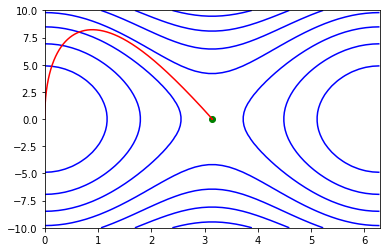

In [5]:
x0 = np.array([.0, 0.])

t = np.linspace(0. * math.pi, 2. * math.pi)
td = np.linspace(-10., 10.)

T, Td = np.meshgrid(t, td)
E = np.array([TotalEnergy(t, td, PendulumParams()) for t, td in zip(np.ravel(T), np.ravel(Td))]).reshape(T.shape)
plt.contour(T, Td, E, colors='b')

builder = DiagramBuilder()

pendulum = builder.AddSystem(PendulumPlant())
controller = builder.AddSystem(BalancingLQR())
builder.Connect(pendulum.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), pendulum.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

state = context.get_mutable_continuous_state_vector()

context.set_time(0.)
state.SetFromVector(x0)
simulator.StepTo(10.)
plt.scatter(math.pi, 0., facecolor='g')
plt.plot(logger.data()[0, :], logger.data()[1, :], color='r')
plt.show()